# Tutorial

## Relevant imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyforfluids as pff
import chemicals

## Definition of the model to be used

In [2]:
model = pff.models.GERG2008()

## Fluid's initial state

In [3]:
temperature = 250  # Degrees Kelvin
density = 1  # mol/L
pressure = 101325  # Pa
composition = {'methane': 0.9, 'ethane': 0.05, 'propane': 0.05}  # Molar fractions

### Definition of the fluid
The properties will be calculated at the moment of the object definition.

In [4]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    density=density
)

#### Pressure as an init variable
Pressure can be used as an initial variable, in this case the method `fluid.density_iterator` will be called internally to find the root of density at the given pressure, since all models use density as an independent variable instead of temperature. 

This can lead to trouble since multiple roots can be obtained in the equilibrium region!

In [5]:
fluid = pff.Fluid(
    model=model,
    composition=composition,
    temperature=temperature,
    pressure=pressure
)

### Accessing properties

Properties are stored in the Fluid attribute `Fluid.properties` as a dictionary, they can either be accessed that way or by calling them directly from the fluid.

All the properties are expressed in **International System** units, except for density that's expressed in **[mol/L]**

In [6]:
fluid.properties

critical_density                                                          9.442773
critical_temperature                                                    207.106811
ideal_helmholtz                  [[-1.4648338367393778, 0.0, 0.0], [192.9025895...
residual_helmholtz               [[-0.004185073700756314, 0.0, 0.0], [-0.806509...
ar_x                             [-0.0041889410624157, 0.0, 0.0, -0.00416396025...
ar_dx                            [-0.8072744747399465, 0.0, 0.0, -0.80225571856...
ar_tx                            [-0.0108604494306309, 0.0, 0.0, -0.01160250616...
ar_xx                            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dvr_dx                           [0.20451237337230468, 0.0, 0.0, 0.250642937311...
dtr_dx                           [397.89662106931627, 0.0, 0.0, 521.78975121897...
dvr2_dx2                         [0.19725144473637551, 0.17882849453231878, 0.1...
dtr2_dx2                         [381.128, 252.384, 608.2564, 595.7192391305018...
dvr2

In [7]:
fluid['isochoric_heat']

28.14582568798458

### State changes

A fluid thermodynamic variable can be changed by using the methods:

- `Fluid.set_temperature`
- `Fluid.set_composition`
- `Fluid.set_density`
- `Fluid.set_pressure`

When a property is changed, the properties are not re-calculated, so it's a **must** to call the method `Fluid.calculate_properties`. This is intended to avoid useless calculations if two or more variables are to be changed. In the case of a pressure change `Fluid.density_iterator` will be called!

In [8]:
fluid.set_temperature(280)
fluid.set_density(2)

fluid.calculate_properties()

In [9]:
fluid['isochoric_heat']

30.65088482829082

## Calculating isotherms

Isotherms at the fluid temperature can be calculated along a density range with the method `Fluid.isotherm`. This will return a dictionary equivalent to the `Fluid.properties` one, but each value will be a list instead of a single value.

In [10]:
density_range = np.linspace(0.001, 20, 100)
isotherm = fluid.isotherm(density_range)

In [11]:
isotherm['pressure'][:5]

0    2.327898e+03
1    4.663138e+05
2    9.180630e+05
3    1.357953e+06
4    1.786371e+06
Name: pressure, dtype: float64

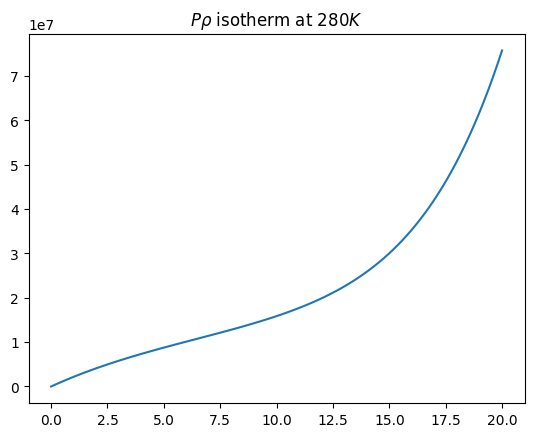

In [12]:
plt.title(r'$P\rho$ isotherm at 280$K$')

plt.plot(density_range, isotherm['pressure'])
plt.show()

## Equilibrium

In [39]:
flash_pt = pff.equilibrium.flash_pt

composition = {'propane': 0.01, 'butane': 0.5, 'isobutane': 0.15, 'pentane': 0.2, 'hexane': 0.14}
temperature = 366.48
pressure = 1.039e6

fluid = pff.Fluid(
    model=pff.models.GERG2008(),
    composition=composition,
    temperature=temperature,
    density=1,
)

vapor, liquid, beta, it = flash_pt(fluid, pressure, temperature)

/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/equilibrium/flash.py:130: RuntimeWarning: divide by zero encountered in true_divide
  b_max = (1 - z) / (1 - k)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/equilibrium/flash.py:136: RuntimeWarning: divide by zero encountered in true_divide
  b_min = (k * z - 1) / (k - 1)


In [40]:
vapor

Fluid(model=GERG2008, temperature=366.48, pressure=1039000.0000, density=0.4236, composition={'propane': 0.02405919, 'butane': 0.59222959, 'isobutane': 0.22051554, 'pentane': 0.11992022, 'hexane': 0.04327129})

In [41]:
liquid

Fluid(model=GERG2008, temperature=366.48, pressure=1039000.0000, density=7.7999, composition={'propane': 0.00892179, 'butane': 0.49292686, 'isobutane': 0.14459213, 'pentane': 0.20614136, 'hexane': 0.14741818})

/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/gerg2008.py:351: RuntimeWarning: invalid value encountered in log
  lnfug = dnar_dn - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/gerg2008.py:351: RuntimeWarning: invalid value encountered in log
  lnfug = dnar_dn - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/gerg2008.py:351: RuntimeWarning: invalid value encountered in log
  lnfug = dnar_dn - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/gerg2008.py:351: RuntimeWarning: invalid value encountered in log
  lnfug = dnar_dn - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/gerg2008.py:351: RuntimeWarning: invalid value encountered in log
  lnfug = dnar_dn - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/gerg2008.py:351: RuntimeWarning: invalid value encountered in log
  lnfug = dnar_dn - np.log(z)
/home/fedebenell

(-1558500.0, 1558500.0)

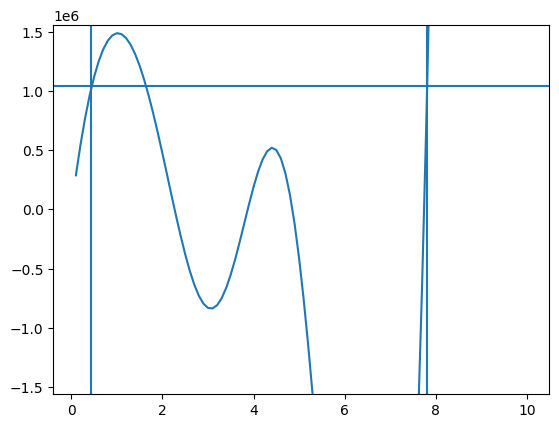

In [16]:
ds = np.linspace(0.1, 10, 100)
iso = fluid.isotherm(ds)

plt.plot(iso["density"], iso["pressure"])
plt.axhline(pressure)
plt.axvline(liquid.density)
plt.axvline(vapor.density)

plt.ylim(-pressure*1.5, pressure*1.5)

In [17]:
# Using chemicals library to get pure compound properties
pc = []
tc = []
w = []
z = []
names = []

for component in composition:
    chem = chemicals.CAS_from_any(component)
    tc.append(chemicals.Tc(chem))
    pc.append(chemicals.Pc(chem)/1e5)
    w.append(chemicals.acentric.omega(chem))
    z.append(composition[component])
    names.append(component)

In [18]:
pr = pff.models.CubicEOS(
    model="PR",
    mix_rule="ClassicVdW",
    names=names,
    critical_temperature=tc,
    critical_pressure=pc,
    acentric_factor=w,
    kij_matrix=np.zeros((5,5)),
    lij_matrix=0*np.zeros((5,5))
)

In [19]:
cfluid = fluid.copy(model=pr)

In [20]:
ciso = cfluid.isotherm(ds)

/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/cubic.py:150: RuntimeWarning: invalid value encountered in log
  lnfug = ar_dn / (self.r * temperature) - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/cubic.py:150: RuntimeWarning: invalid value encountered in log
  lnfug = ar_dn / (self.r * temperature) - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/cubic.py:150: RuntimeWarning: invalid value encountered in log
  lnfug = ar_dn / (self.r * temperature) - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/cubic.py:150: RuntimeWarning: invalid value encountered in log
  lnfug = ar_dn / (self.r * temperature) - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/cubic.py:150: RuntimeWarning: invalid value encountered in log
  lnfug = ar_dn / (self.r * temperature) - np.log(z)
/home/fedebenelli/docs/research/thermo/algos/pff/pyforfluids/models/cubic.py:150

(-1000000.0, 20000000.0)

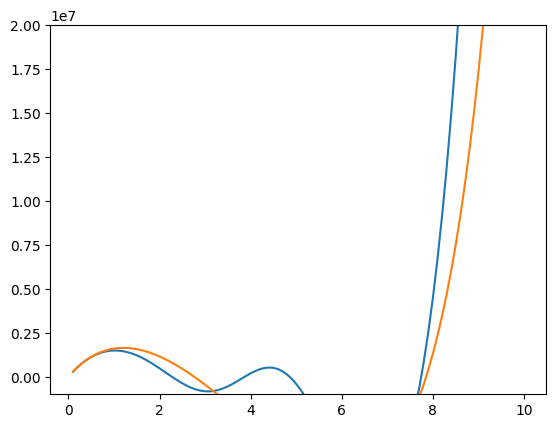

In [21]:
plt.plot(iso["density"], iso["pressure"])
plt.plot(ciso["density"], ciso["pressure"])
plt.ylim(-1e6, 0.2e8)

In [22]:
cvapor, cliquid, cbeta, it = flash_pt(cfluid, pressure, temperature)

In [23]:
cvapor

Fluid(model=Cubic EoS: PR, temperature=366.48, pressure=1039000.0000, density=0.4246, composition={'propane': 0.02368936, 'butane': 0.59963775, 'isobutane': 0.21662462, 'pentane': 0.11869091, 'hexane': 0.04135238})

In [24]:
cliquid

Fluid(model=Cubic EoS: PR, temperature=366.48, pressure=1039000.0002, density=7.9639, composition={'propane': 0.00897916, 'butane': 0.49256981, 'isobutane': 0.14503167, 'pentane': 0.20606339, 'hexane': 0.14735636})

In [25]:
cbeta

0.06939697265625

In [26]:
cvapor.composition

{'propane': 0.02368936,
 'butane': 0.59963775,
 'isobutane': 0.21662462,
 'pentane': 0.11869091,
 'hexane': 0.04135238}

In [27]:
vapor.composition

{'propane': 0.02405919,
 'butane': 0.59222959,
 'isobutane': 0.22051554,
 'pentane': 0.11992022,
 'hexane': 0.04327129}

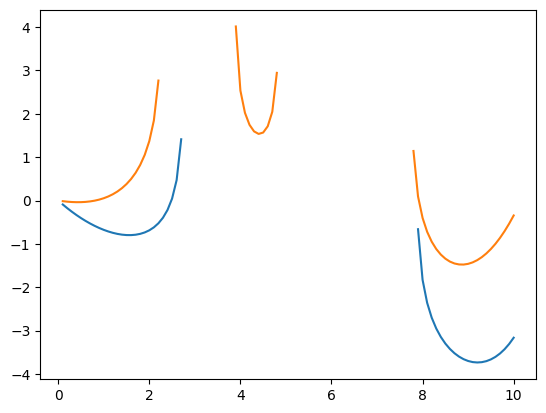

In [28]:
plt.plot(ciso["density"], ciso["lnfug"].apply(lambda x: x[4]))
plt.plot(iso["density"], iso["lnfug"].apply(lambda x: x[4]))

In [67]:
k = gfluid.model.set_concentration(vapor.composition)/gfluid.model.set_concentration(liquid.composition)

/tmp/ipykernel_810845/2389725898.py:1: RuntimeWarning: invalid value encountered in true_divide
  k = gfluid.model.set_concentration(vapor.composition)/gfluid.model.set_concentration(liquid.composition)


In [68]:
z = gfluid.model.set_concentration(gfluid.composition)

In [69]:
msk = np.isnan(k)
k = k[~msk]
z = z[~msk]

In [70]:
k

array([2.69667746, 1.2014553 , 1.52508674, 0.58173779, 0.2935275 ])

In [71]:
z

array([0.01, 0.5 , 0.15, 0.2 , 0.14])

In [77]:
pff.equilibrium.solve_rr(z, k*2)

(array([0.01, 0.5 , 0.15, 0.2 , 0.14]),
 array([0.01, 0.5 , 0.15, 0.2 , 0.14]),
 1,
 1)

In [78]:
k*2

array([5.39335492, 2.40291061, 3.05017348, 1.16347559, 0.587055  ])

In [86]:
pff.equilibrium.bub_t(gfluid, pressure)

ValueError: f(a) and f(b) must have different signs

In [89]:
pff.equilibrium.bub_t(gfluid, pressure)

ValueError: f(a) and f(b) must have different signs